In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.metrics import accuracy_score
from catboost import CatBoostRegressor, Pool
import warnings
warnings.filterwarnings("ignore")
from DataPlotLib import make_heatmap


In [2]:
class RMSLE(object):
    def calc_ders_range(self, approxes, targets, weights):
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)

        result = []
        for index in range(len(targets)):
            val = np.maximum(approxes[index], 0)
            der1 = np.log1p(targets[index]) - np.log1p(np.maximum(0, approxes[index]))
            der2 = -1 / (np.maximum(0, approxes[index]) + 1)

            if weights is not None:
                der1 *= weights[index]
                der2 *= weights[index]

            result.append((der1, der2))
        return result

class RMSLE_val(object):
    def get_final_error(self, error, weight):
        return np.sqrt(error / (weight + 1e-38))

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            error_sum += w * ((np.log1p(np.maximum(0, approx[i])) - np.log1p(np.maximum(0, target[i])))**2)

        return error_sum, weight_sum

In [3]:
train_df = pd.read_csv(r'E:\Downloads\playground-series-s4e4\train.csv')

In [4]:
train_df

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
...,...,...,...,...,...,...,...,...,...,...
90610,90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6
90613,90613,I,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


In [6]:
train_df.drop(axis=1, columns=['id'], inplace=True)
train_df

,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9
...,...,...,...,...,...,...,...,...,...
90610,M,0.335,0.235,0.075,0.1585,0.0685,0.0370,0.0450,6
90611,M,0.555,0.425,0.150,0.8790,0.3865,0.1815,0.2400,9
90612,I,0.435,0.330,0.095,0.3215,0.1510,0.0785,0.0815,6
90613,I,0.345,0.270,0.075,0.2000,0.0980,0.0490,0.0700,6


### EDA

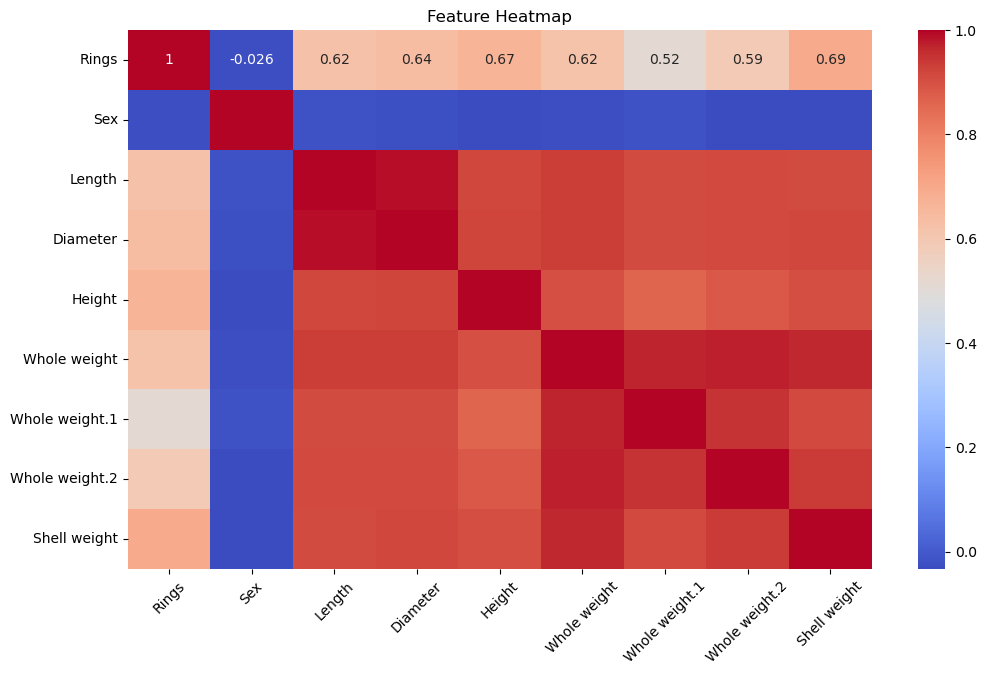

In [7]:
make_heatmap(train_df.columns, train_df, 'Rings')

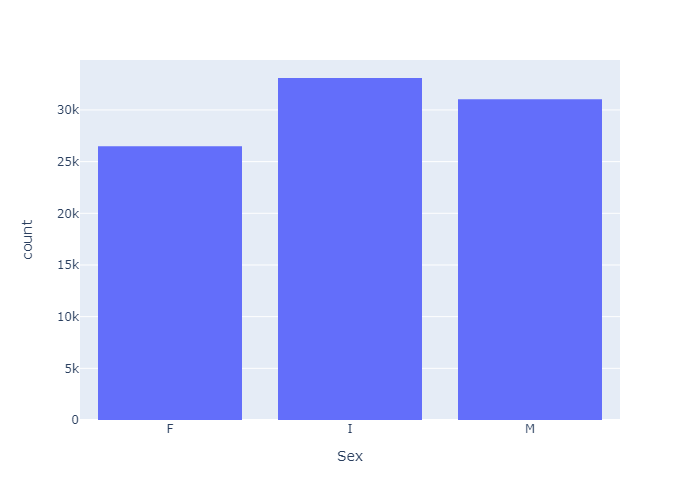

In [17]:
fig = px.histogram(train_df, x='Sex')
fig.show("png")

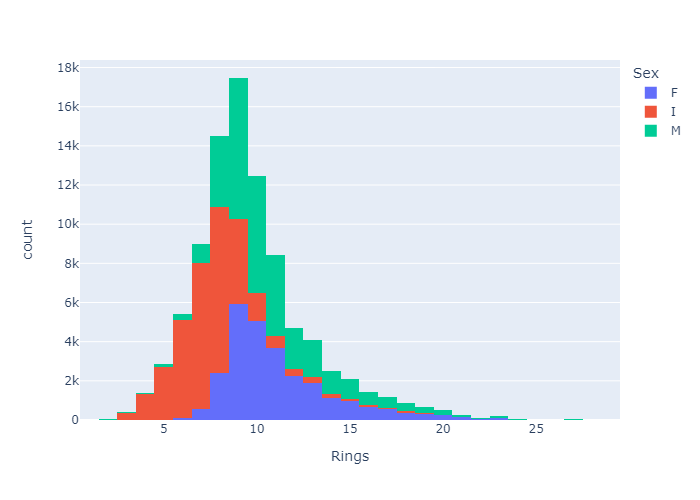

In [18]:
fig = px.histogram(train_df, x='Rings', color='Sex')
fig.show("png")

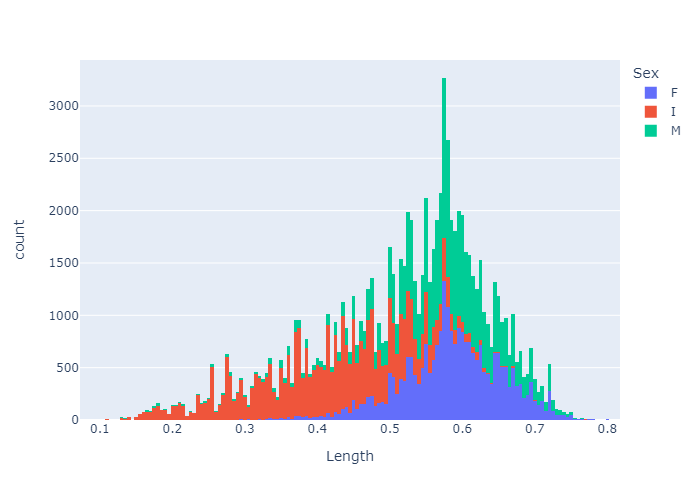

In [19]:
fig = px.histogram(train_df, x='Length', color='Sex')
fig.show("png")

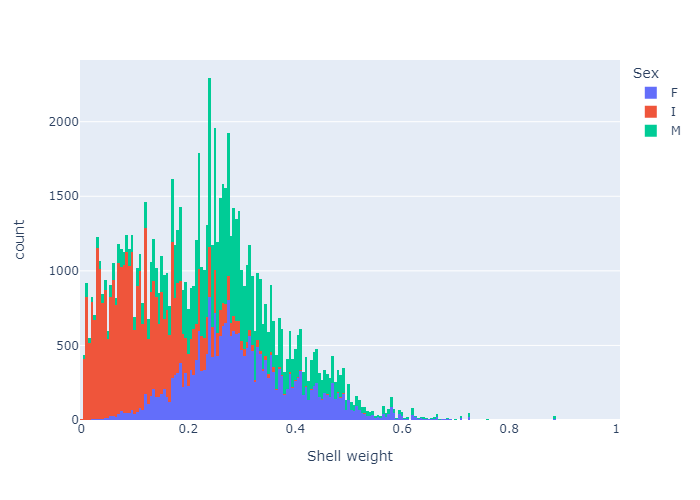

In [20]:
fig = px.histogram(train_df, x='Shell weight', color='Sex')
fig.show("png")

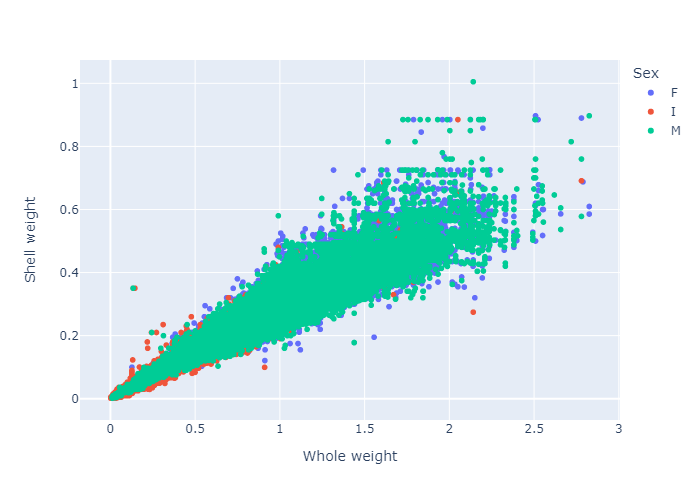

In [21]:
fig = px.scatter(train_df, x='Whole weight', y='Shell weight', color='Sex')
fig.show("png")

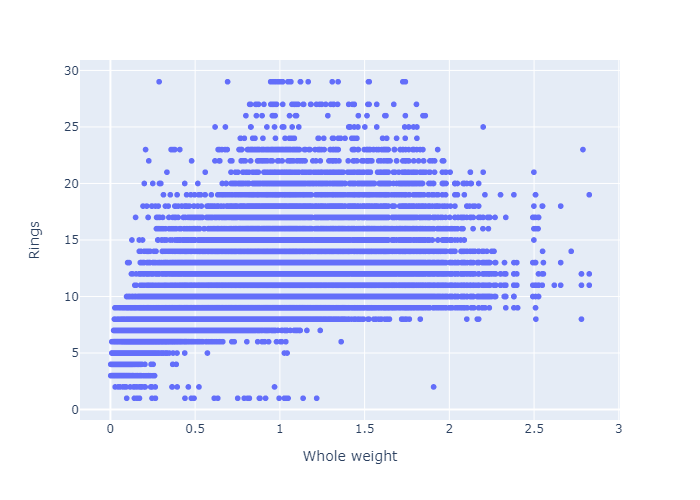

In [22]:
fig = px.scatter(train_df, y='Rings', x='Whole weight')
fig.show("png")

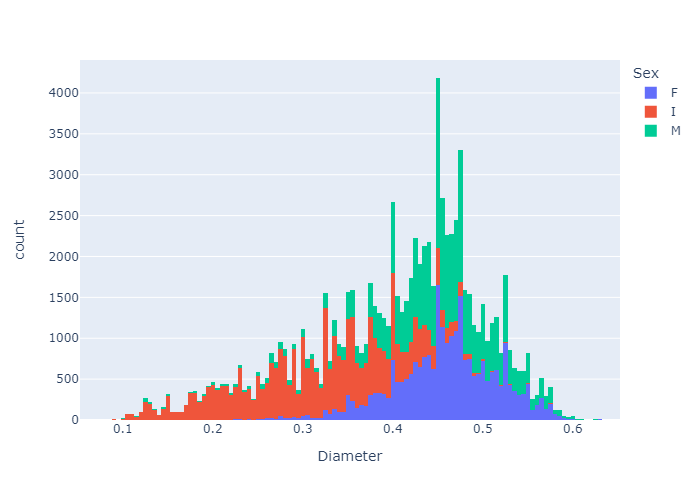

In [23]:
fig = px.histogram(train_df, x='Diameter', color='Sex')
fig.show("png")

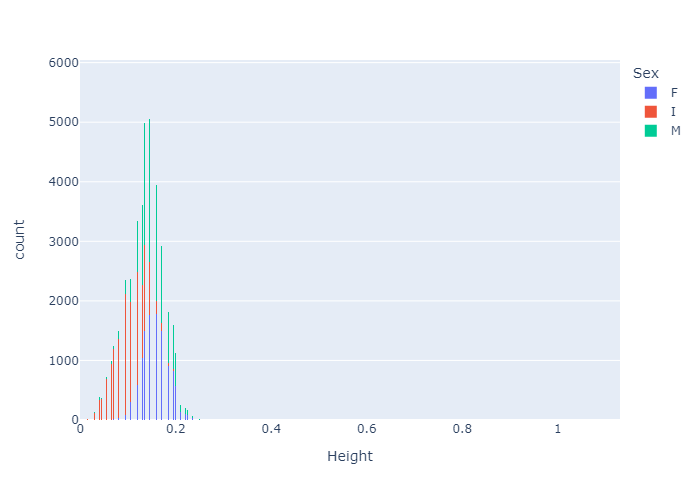

In [24]:
fig = px.histogram(train_df, x='Height', color='Sex')
fig.show("png")

### Feature Engineering

In [ ]:
train_df['LD_Ratio'] = train_df['Length'] / train_df['Diameter']
train_df['HD_Ratio'] = train_df['Height'] / train_df['Diameter']
train_df['LH_Ratio'] = train_df['Length'] / train_df['Height']
train_df['ShellWeightRatio'] =  train_df['Shell weight'] / train_df['Whole weight'] 
train_df['WholeWeight1Ratio'] = train_df['Whole weight.1'] / train_df['Whole weight'] 
train_df['WholeWeight2Ratio'] = train_df['Whole weight.2'] / train_df['Whole weight'] 

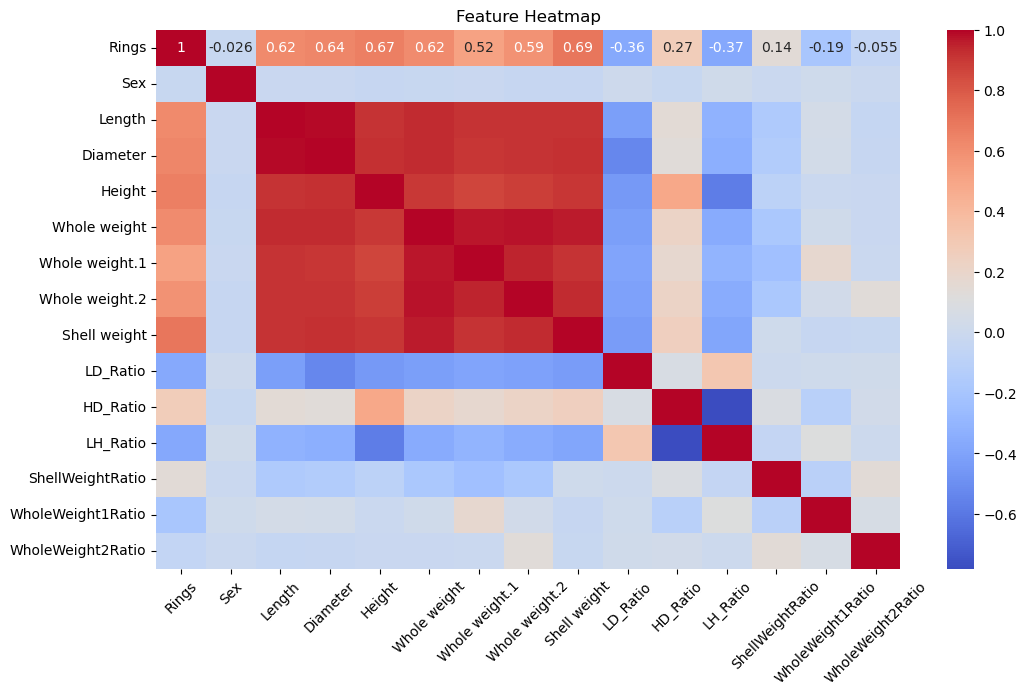

In [17]:
make_heatmap(train_df.columns, train_df, 'Rings')

### Модель

In [18]:
X = train_df.drop(axis=1, columns=['Rings'])
y = train_df['Rings']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
cbc = CatBoostRegressor(loss_function=RMSLE(), cat_features=['Sex'],eval_metric=RMSLE_val())
model = cbc.fit(X_train, y_train, eval_set=(X_test,y_test), verbose=500)

0:	learn: 2.2790808	test: 2.2784480	best: 2.2784480 (0)	total: 1.5s	remaining: 25m 1s
500:	learn: 0.1491507	test: 0.1528230	best: 0.1528230 (500)	total: 11m 34s	remaining: 11m 31s
999:	learn: 0.1473952	test: 0.1521266	best: 0.1521264 (991)	total: 23m 9s	remaining: 0us

bestTest = 0.1521263531
bestIteration = 991

Shrink model to first 992 iterations.


### RandomSearch

In [ ]:
cbc = CatBoostRegressor(loss_function=RMSLE(), cat_features=['Sex'],eval_metric=RMSLE_val(), verbose=100)
grid = {'iterations':np.arange(300, 1000, 100),
        'early_stopping_rounds': [300],
        'depth':np.arange(3, 10, 1),
        'l2_leaf_reg': np.arange(3, 11, 1),
        'learning_rate': np.linspace(0.05, 0.2, 15)
       }
randomized_search_result = cbc.randomized_search(grid,
                                                   X=train_df.drop(axis=1, columns=['Rings']),
                                                   y=train_df['Rings'],
                                                   train_size=0.8,
                                                   plot=True)

### Submission

In [ ]:
test_df = pd.read_csv(r'E:\Downloads\playground-series-s4e4\test.csv')

In [ ]:
test_df.drop(axis=1, columns=['id'], inplace=True)
test_df['LD_Ratio'] = test_df['Length'] / test_df['Diameter']
test_df['HD_Ratio'] = test_df['Height'] / test_df['Diameter']
test_df['LH_Ratio'] = test_df['Length'] / test_df['Height']
test_df['ShellWeightRatio'] =  test_df['Shell weight'] / test_df['Whole weight'] 
test_df['WholeWeight1Ratio'] = test_df['Whole weight.1'] / test_df['Whole weight'] 
test_df['WholeWeight2Ratio'] = test_df['Whole weight.2'] / test_df['Whole weight'] 

In [ ]:
test_df

In [50]:
y_pred = model.predict(test_df)
sample = pd.read_csv(r'E:\Downloads\playground-series-s4e4\sample_submission.csv')
sample['Rings'] = y_pred
sample.to_csv(r'E:\Downloads\playground-series-s4e4\sample_submissionans.csv', index=False)